In [1]:
import pandas
import numpy as np
import matplotlib as mlp
import seaborn
import matplotlib.pyplot as plt
from statistics import mean
from tqdm.notebook import tqdm
from IPython.display import display
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
RAND_SEED = 6758 # To make sure that all runs are similar
SPLIT = 0.4 # proportion of dataset to be considered as Test set

In [3]:
df_orig = pandas.read_csv('../data/accounts.csv.gz')

## Analysing comment patterns

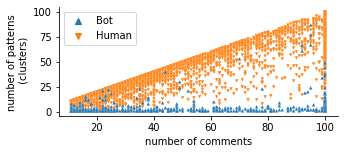

In [4]:
fig, ax = plt.subplots(figsize=[5,2])

classes = {1: "Bot", 0: "Human"}

ax = seaborn.scatterplot(
    data=df_orig.replace({'bot':classes}).sort_values('bot',ascending=False),
    x='comments',
    y='clusters',
    hue='bot',
    style='bot',
    markers=['v','^'],
    x_jitter=10,
    y_jitter=10,
    hue_order=["Bot", 'Human'],
    s=12,
    linewidth=.1, alpha = 1,
    ax = ax,
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_ylabel('number of patterns \n (clusters)')
ax.set_xlabel('number of comments')
fig.savefig('../figures/scatter_cms_clusters.pdf', bbox_inches='tight')

## Empty comments

In [5]:
print("Precentage of bots with empty comments: ",100*len(df_orig.query('bot == 1 and empty_comments > 0')) / len(df_orig.query('bot == 1')))
print("Precentage of humans with empty comments: ",100*len(df_orig.query('bot == 0 and empty_comments > 0')) / len(df_orig.query('bot == 0')))

Precentage of bots with empty comments:  7.020872865275142
Precentage of humans with empty comments:  41.2921976302258


## Accounts with minimum number of comments

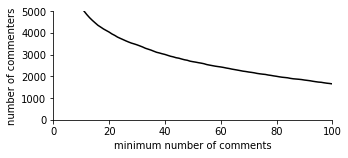

In [6]:
fig,ax = plt.subplots(figsize=(5,2))

for item in ['comments']:
    ax = (
        df_orig
        [[item,'account']]
        .groupby(item).count()
        .sort_index(ascending= False)
        .cumsum()
        .rename(columns={'account':item})
    ).plot(ax=ax,label = item,c='black')

ax.set_xlabel('minimum number of comments')
ax.set_ylabel('number of commenters')
ax.set_xlim(0,100)
ax.set_ylim(0,5000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_legend().remove()

fig.savefig('../figures/comments_accounts.pdf', bbox_inches='tight')

## Analysing inequality of comments in patterns

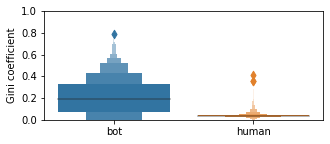

In [7]:
fig,ax = plt.subplots(figsize=(5,2))

ax = seaborn.boxenplot(
    data = df_orig.assign(type = lambda x: np.where(x['bot']==1,'bot','human')),
    x = 'type',
    y = 'gini',
)
ax.set_xlabel('')
ax.set_ylim(0,1)
ax.set_ylabel('Gini coefficient')
fig.savefig('../figures/ginidistribution.pdf', bbox_inches='tight')

In [8]:
from scipy.stats import mannwhitneyu

def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size


def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

In [9]:
# gini of bot accounts
p1 = df_orig[lambda x: x['bot']==1].gini
# gini of human accounts
p2 = df_orig[lambda x: x['bot']==0].gini

print(mannwhitneyu(p1,p2))
print("Effect size Cliffs Delta: ",cliffsDelta(p1,p2))

MannwhitneyuResult(statistic=490703.0, pvalue=4.475294861833513e-107)
Effect size Cliffs Delta:  (0.5836685726842608, 'large')


# Split DF for train an test

In [10]:
from sklearn.model_selection import train_test_split 

df = (
    # Having a copy of original data
    df_orig.copy()
    .reset_index()
)

def train_test_split(dataframe, test_split=.4, randstate=123):
    # Set of bots
    bots = df[lambda x: x['bot']==1 ]
    # Set of humans
    humans = df[lambda x: x['bot']==0 ]

    # Split of bots for the test set
    df_test_bot = bots.sample(round(SPLIT *len(bots)),random_state=randstate)
    # Split of bots for the train set
    df_train_bot = df.iloc[bots[lambda x: ~bots.index.isin(df_test_bot.index)].index]

    # Split of humans for the test set
    df_test_human = humans.sample(round(SPLIT *len(humans)),random_state=randstate)
    # Split of humans for the train set
    df_train_human = df.iloc[humans[lambda x: ~humans.index.isin(df_test_human.index)].index]

    # Create the train set 
    df_train = (pandas.concat([df_train_bot,df_train_human]))
    # Create the test set 
    df_test = (pandas.concat([df_test_human,df_test_bot]))
    
    return df_train,df_test

df_train, df_test = train_test_split(df,test_split=SPLIT,randstate=RAND_SEED)

In [11]:
print('Train set \nSize: ',len(df_train))
print('Number of bot accounts: ',len(df_train[lambda x: x['bot'] == 1]))
print('Number of human accounts: ',len(df_train[lambda x: x['bot'] == 0]))

print('\nTest set \nSize: ',len(df_test))
print('Number of bot accounts: ',len(df_test[lambda x: x['bot'] == 1]))
print('Number of human accounts: ',len(df_test[lambda x: x['bot'] == 0]))

Train set 
Size:  3000
Number of bot accounts:  316
Number of human accounts:  2684

Test set 
Size:  2000
Number of bot accounts:  211
Number of human accounts:  1789


In [12]:
## selected features
features = ['comments','empty_comments','clusters','gini']

# Precision functions

In [13]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support,classification_report, confusion_matrix, accuracy_score

def botrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred)[1][1]
bot_recall = make_scorer(botrecall, greater_is_better=True)

def botprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred)[0][1]
bot_precision = make_scorer(botprecision, greater_is_better=True)

def humanrecall(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred)[1][0]
human_recall = make_scorer(humanrecall, greater_is_better=True)

def humanprecision(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred)[0][0]
human_precision = make_scorer(humanprecision, greater_is_better=True)

def botfscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred)[2][1]
bot_fscore = make_scorer(botfscore, greater_is_better=True)

def humanfscore(y_true, y_pred):
    return precision_recall_fscore_support(y_true,y_pred)[2][0]
human_fscore = make_scorer(humanfscore, greater_is_better=True)

def wpscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted')[0]
wprecision_score = make_scorer(wpscore, greater_is_better=True)

def wrscore(y_true, y_pred):   
    return precision_recall_fscore_support(y_true,y_pred,average='weighted')[1]
wrecall_score = make_scorer(wrscore, greater_is_better=True)

# Best parameter and model search

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Set of parameters for K-neighbor classifier
knc_param_grid = {'n_neighbors': [2,4],
                  'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

# Set of parameters for decision Tree classifier
dtc_param_grid = {'max_depth': [4,5, 6, 8,10],
                  'criterion':['gini','entropy'],
                  'class_weight':['balanced']}

# Set of parameters for random forest classifier
rfc_param_grid = {'max_depth': [4,5,6, 8,10],
              'n_estimators':[10,20,50,100,120],
              'criterion':['gini','entropy'],
              'class_weight':[ 'balanced']}

# Set of parameters for logistic regression classifier
lrc_param_grid = {'penalty': ['l1', 'l2', 'elasticnet','none'],
              'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
              'class_weight':[ 'balanced']}

# Set of parameters for support vector machine classifier
svc_param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'class_weight':[ 'balanced']}

# Set of parameters for ZeroR Classifier
zeror_param_grid = {'strategy': ['most_frequent']}

classifiers = {'KNeighborsClassifier':KNeighborsClassifier(),
               'DecisionTreeClassifier':DecisionTreeClassifier(random_state=RAND_SEED),
               'RandomForestClassifier':RandomForestClassifier(random_state=RAND_SEED),
               'LogisticRegression':LogisticRegression(random_state=RAND_SEED),
               'SVC':SVC(random_state=RAND_SEED),
               'ZeroRClassifier':DummyClassifier(random_state=RAND_SEED)}
classifiers_params ={
               'KNeighborsClassifier':knc_param_grid,
               'DecisionTreeClassifier':dtc_param_grid,
               'RandomForestClassifier':rfc_param_grid,
               'LogisticRegression':lrc_param_grid,
               'SVC':svc_param_grid,
               'ZeroRClassifier':zeror_param_grid
}

Result = pandas.DataFrame()

# Start grid search for each classifier
for item in classifiers.keys():
    search = GridSearchCV(classifiers[item],  classifiers_params[item],
                      cv=StratifiedShuffleSplit(n_splits = 10, random_state=RAND_SEED),
                      scoring={'bot_f1':bot_fscore,'human_f1':human_fscore,
                               'f1_micro':'f1_micro','f1_macro':'f1_macro',
                               'f1_weighted':'f1_weighted',
                               'bot_precision':bot_precision,
                               'bot_recall':bot_recall,
                               'recall':wrecall_score,
                               'precision':wprecision_score,
                               'human_precision':human_precision,
                               'human_recall':human_recall
                              },refit=False)
    search.fit(df_train[features].values,df_train[['bot']].values)
    # Create a data frame of resulting classifiers with precision scores
    Result = Result.append(
        pandas.DataFrame()
        .from_dict(search.cv_results_)
        .assign(Method=item)
    )

In [15]:
print('Number of created classifiers: ' ,len(Result))

Number of created classifiers:  92


In [16]:
(
    Result
    .sort_values('mean_test_f1_weighted',ascending=False)
    .round(3)
    .drop_duplicates('Method')
    [['Method','params','mean_test_bot_precision','mean_test_bot_recall','mean_test_human_precision','mean_test_human_recall','mean_test_precision','mean_test_recall','mean_test_f1_weighted']]
)

,Method,params,mean_test_bot_precision,mean_test_bot_recall,mean_test_human_precision,mean_test_human_recall,mean_test_precision,mean_test_recall,mean_test_f1_weighted
45,RandomForestClassifier,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10}",0.932,0.916,0.990,0.992,0.984,0.984,0.984
7,KNeighborsClassifier,"{'algorithm': 'brute', 'n_neighbors': 4}",0.943,0.853,0.983,0.994,0.978,0.979,0.978
1,SVC,"{'class_weight': 'balanced', 'kernel': 'rbf'}",0.876,0.925,0.991,0.984,0.979,0.978,0.978
4,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10}",0.882,0.884,0.986,0.985,0.975,0.974,0.974
8,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}",0.839,0.931,0.992,0.978,0.975,0.973,0.974
0,ZeroRClassifier,{'strategy': 'most_frequent'},0.000,0.000,0.893,1.000,0.798,0.893,0.843


In [17]:
# Construct final model
model = RandomForestClassifier(class_weight='balanced',criterion='entropy',n_estimators=10,max_depth=10,random_state=RAND_SEED)
model.fit(df_train[features].values,df_train['bot'].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=6758,
                       verbose=0, warm_start=False)

In [18]:
import pickle

# Dump model in a pickle file
filename = "../model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(model, file)